# CS4487 - Machine Learning
# Lecture 5b - Supervised Learning - Regression
## Dr. Antoni B. Chan
### Dept. of Computer Science, City University of Hong Kong

# Outline
1. Linear Regression
2. Selecting Features
3. **Removing Outliers**
4. Non-linear regression

In [1]:
# setup
%matplotlib inline
import IPython.core.display         # setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

D:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
D:\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Outliers
- Too many outliers in the data can affect the squared-error term.
  - regression function will try to reduce the large prediction error for outliers, at the expense of worse prediction for other points
  

In [2]:
linbias = 30
[linX, linY, lincoefs] = datasets.make_regression(n_samples=100, n_features=1, 
                                                  n_informative=1, bias=linbias, noise=5.0, 
                                                  coef=True, random_state=4487)
# outliers
outbias = 10
[outX, outY, outcoefs] = datasets.make_regression(n_samples=10, n_features=1, 
                                                  n_informative=1, bias=outbias, noise=5.0, 
                                                  coef=True, random_state=447)

# combine
outlinX = r_[linX, 2+outX/2]
outlinY = r_[linY, outY]

# fit using ordinary least squares
ols = linear_model.LinearRegression()
ols.fit(outlinX, outlinY)

# fit using ridge regression
alpha = 100
rr = linear_model.Ridge(alpha=alpha)
rr.fit(outlinX, outlinY)

axbox = [-3, 4, -40, 100]

xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
ypred = ols.predict(xr)
ypredrr = rr.predict(xr)

outfig = plt.figure()
plt.plot(outlinX, outlinY, 'b.')
plt.plot(xr, ypred, 'r-', label="OLS")
plt.plot(xr, ypredrr, 'm-', label='RR $\\alpha='+str(alpha)+'$')
plt.xlabel('feature x'); plt.ylabel('output y')
plt.grid(True); plt.axis(axbox)
plt.legend(loc='upper left')
plt.close()

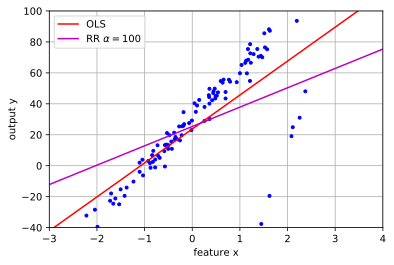

In [3]:
outfig

# RANSAC
- **RAN**dom **SA**mple **C**onsensus
  - attempt to robustly fit a regression model in the presence of corrupted data (outliers).
  - works with any regression model.
- **Idea:**
  - split the data into inliers (good data) and outliers (bad data).
  - learn the model only from the inliers

# Random sampling
- Repeat many times...
  - randomly sample a subset of points from the data. Typically just enough to learn the regression model
  - fit a model to the subset.
  - classify all data as inlier or outlier by calculating the residuals (prediction errors) and comparing to a threshold.  The set of inliers is called the _consensus set_.
  - save the model with the highest number of inliers.
- Finally, use the largest consensus set to learn the final model.

In [4]:

random.seed(1002)
ransacfig = plt.figure(figsize=(12,3))
for i in range(3):    
    inds = [random.choice(range(len(outlinY))) for j in range(2)]
    
    ols = linear_model.LinearRegression()
    ols.fit(outlinX[inds], outlinY[inds])

    ypred = ols.predict(xr)
    T = 15
    
    # calculate number of inliers
    ytpred = ols.predict(outlinX)
    numin = sum(abs(ytpred-outlinY)<=T)
    
    plt.subplot(1,3,i+1)
    plt.plot(outlinX, outlinY, 'b.', markeredgecolor='k')
    plt.plot(outlinX[inds], outlinY[inds], 'ro', label='selected points', markeredgecolor='k')
    plt.plot(xr, ypred, 'r-', label='estimated line')
    plt.plot(xr, ypred+T, 'r--', linewidth=1, label='inlier threshold')
    plt.plot(xr, ypred-T, 'r--', linewidth=1)
    plt.grid(True); plt.axis(axbox)
    plt.title("number of inliers = " + str(numin))
    if i==0:
        plt.legend(fontsize=8, loc='upper left')


plt.close()

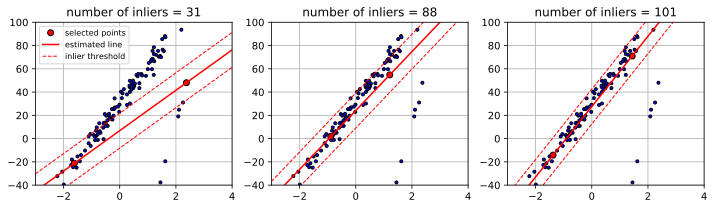

In [5]:
ransacfig

# RANSAC
- More iterations increases the probability of finding the correct function.
  - higher probability to select a subset of points contains all inliers.
- Threshold typically set as the median absolute deviation of $y$.

In [6]:
def plot_regr_trans_1d(model, axbox, X, Y, feattrans=None):
    xr = linspace(axbox[0], axbox[1], 100)

    # predict the function
    if feattrans != None:
        xrf   = feattrans(xr[:,newaxis])
    else:
        xrf = xr[:,newaxis]
    Ypred = model.predict(xrf)

    plt.plot(X, Y, 'b.')
    plt.plot(xr, Ypred, 'r-')
    plt.axis(axbox); plt.grid(True)

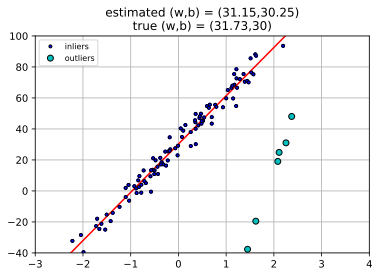

In [7]:
# use RANSAC model (defaults to linear regression)
rlin = linear_model.RANSACRegressor(random_state=1234)
rlin.fit(outlinX, outlinY)

inlier_mask = rlin.inlier_mask_
outlier_mask = logical_not(inlier_mask)

plt.figure()
plot_regr_trans_1d(rlin, axbox, outlinX, outlinY)
plt.plot(outlinX[inlier_mask], outlinY[inlier_mask], 'b.', label='inliers', markeredgecolor='k')
plt.plot(outlinX[outlier_mask], outlinY[outlier_mask], 'co', label='outliers', markeredgecolor='k')
leg = plt.legend(fontsize=8, loc='upper left')
plt.title('estimated (w,b) = (%0.4g,%0.4g)\ntrue (w,b) = (%0.4g,%0.4g)' % 
          (rlin.estimator_.coef_, rlin.estimator_.intercept_, lincoefs, linbias));

# Non-linear regression
- So far we have only considered linear regression: $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$
- Similar to classifcation, we can do non-linear regression by forming a feature vector of $\mathbf{x}$ and then performing linear regression on the feature vector.

# Polynomial regression
- p-th order Polynomial function
  - $f(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \cdots + w_p x^p$
- Collect the terms into a vector
  - $f(x) = \begin{bmatrix}w_0 &w_1 &w_2 &\cdots &w_p\end{bmatrix}*\begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix} = \mathbf{w}^T \phi(x)$ 
  - weight vector $\mathbf{w} = \begin{bmatrix}w_0 \\w_1 \\w_2 \\\vdots \\w_p\end{bmatrix}$; polynomial feature vector: $\phi(x) = \begin{bmatrix}1\\x\\x^2 \\\vdots\\x^p\end{bmatrix}$
- Now it's a linear function, so we can use the same linear regression!

# Example

- 1st to 6th order polynomials

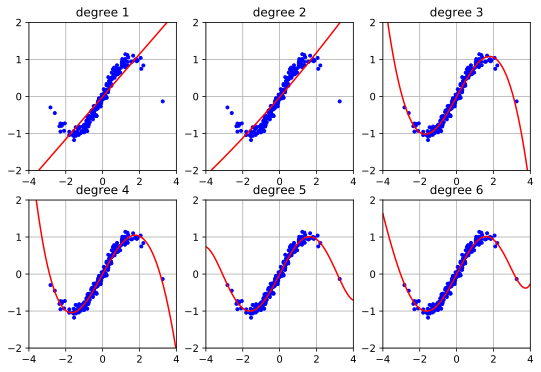

In [8]:
# example data
polyX = random.normal(size=200)
polyY = sin(polyX) + 0.1*random.normal(size=200)
polyX = polyX[:,newaxis]

plt.figure(figsize=(9,6))
axbox = [-4, 4, -2, 2]

for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats = preprocessing.PolynomialFeatures(degree=d)
    polyXf = polyfeats.fit_transform(polyX)

    # fit the parameters
    plin = linear_model.LinearRegression()
    plin.fit(polyXf, polyY)

    # make plot
    plt.subplot(2,3,d)
    plot_regr_trans_1d(plin, axbox, polyX, polyY, polyfeats.transform)
    plt.title("degree " + str(d))

# Example: Boston data
- Using "percentage of lower-status" feature
- Increasing polynomial degree $d$ will decrease MSE of training data
  - more complicated model always fits data better
  - (but it could overfit)

In [9]:
subsamp = 3
boston = datasets.load_boston()
bostonY = boston['target'][::subsamp]
bostonX = boston['data'][::subsamp,12][:,newaxis]
bostonaxbox = [0,40,0,50]

In [10]:
polyfeats = {}
plin = {}
MSE = {}
for d in [1,2,3,4,5,6]:
    # extract polynomial features with degree d
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats[d].fit_transform(bostonX)

    # fit the parameters
    plin[d] = linear_model.LinearRegression()
    plin[d].fit(bostonXf, bostonY)

    # calculate mean-square error on training set
    MSE[d] = metrics.mean_squared_error(bostonY, plin[d].predict(bostonXf))

In [11]:
pfig = plt.figure(figsize=(10,6))
for d in [1,2,3,4,5,6]:
    # make plot
    plt.subplot(2,3,d)
    plot_regr_trans_1d(plin[d], bostonaxbox, bostonX, bostonY, polyfeats[d].transform)
    plt.ylabel('Home Price ($1000s)')
    plt.title('degree={}; MSE={:.5f}'.format(d, MSE[d]), fontsize=10)
plt.close()

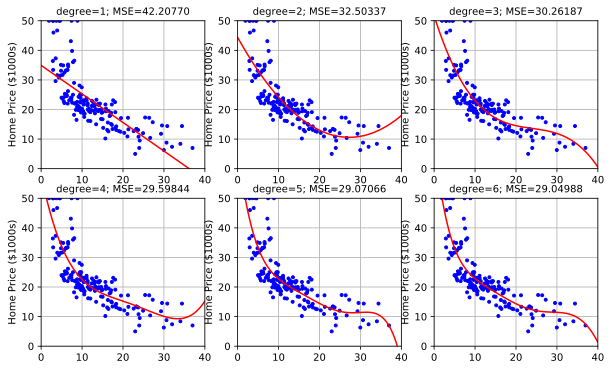

In [12]:
pfig

# Select degree using Cross-Validation
- Minimizing the MSE on the training set will overfit
  - More complex function always has lower MSE on training set
- Use cross-validation to select the proper model
  - the parameters we want to change are in feature transformation step
  - use `pipeline` to merge all steps into one object for easier cross-validation

In [13]:
# make the pipeline
#  each entry is a tuple with the name and transformer (implements fit, transform)
#  the last entry should be a model (implements fit)
polylin = pipeline.Pipeline([
        ('polyfeats', preprocessing.PolynomialFeatures(degree=1)), 
        ('linreg',    linear_model.LinearRegression())
    ])

In [14]:
# set the parameters for grid search
# the parameters in each stage are named: <stage>__<parameter> 
paramgrid = {
    "polyfeats__degree": array([1, 2, 3, 4, 5, 6]),
}

# do the cross-validdation search 
plincv = model_selection.GridSearchCV(polylin, paramgrid, cv=5, n_jobs=-1,
                                      scoring='neg_mean_squared_error')
plincv.fit(bostonX, bostonY)

print(plincv.best_params_)

{'polyfeats__degree': 5}


In [15]:
def extract_grid_scores(modelcv, paramgrid):
    "extract CV scores from GridSearchCV and put into a matrix"
    # get parameters
    pkeys = list(paramgrid.keys())
    
    # initialize empty score matrix
    scoresize = [len(paramgrid[p]) for p in pkeys]
    avgscores = zeros(scoresize)

    # fill in the matrix with run for each parameter set
    for rm,rp in zip(modelcv.cv_results_['mean_test_score'], modelcv.cv_results_['params']):
        # get the index into each of the parameter lists
        myind = [where(rp[p] == paramgrid[p]) for p in pkeys]
        avgscores[tuple(myind)] = rm    # put the score

    # location of best score
    bestind = [where(modelcv.best_params_[p] == paramgrid[p]) for p in pkeys]

    return avgscores, pkeys, bestind

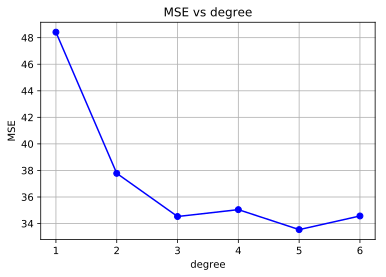

In [16]:
avgscores,pnames,bestind = extract_grid_scores(plincv, paramgrid)
plt.figure()
plt.plot(paramgrid['polyfeats__degree'], -avgscores, 'bo-')
plt.xlabel('degree'); plt.ylabel('MSE'); plt.grid(True);
plt.title('MSE vs degree');

# Polynomial features: 2D Example
- 2D feature: $\mathbf{x} = \begin{bmatrix}x_1 &x_2\end{bmatrix}^T$
- degree 2: $\phi(\mathbf{x}) = \begin{bmatrix}x_1^2& x_1 x_2 & x_2^2\end{bmatrix}^T$
- degree 3: $\phi(\mathbf{x}) = \begin{bmatrix}x_1^3& x_1^2 x_2 & x_1 x_2^2 & x_3^3\end{bmatrix}^T$

In [17]:
def plot_regr_trans_2d(model, axbox, X, Y, feattrans=None):
    # maek grid    
    xr = [linspace(axbox[0],axbox[1],100), 
          linspace(axbox[2],axbox[3],100)]
    xgrid0, xgrid1 = meshgrid(xr[0], xr[1])
    allpts = c_[xgrid0.ravel(), xgrid1.ravel()]
    if feattrans != None:
        allptsf = feattrans(allpts)
    else:
        allptsf = allpts
    
    ypred = model.predict(allptsf).reshape(xgrid0.shape)
    
    vmin = Y.min()-10
    vmax = Y.max()+10
    plt.imshow(ypred, origin='lower', extent=axbox, aspect='auto', 
               vmin=vmin, vmax=vmax, cmap='jet')
    plt.scatter(X[:,0], X[:,1], c=Y, vmin=vmin, vmax=vmax, cmap='jet', edgecolors='k')
    
    plt.grid(True); plt.axis(axbox)

# setup dataset
bostonaxbox2 = [3,9,0,40]
bostonY = boston['target'][::subsamp]
bostonX = boston['data'][::subsamp,[5,12]]

In [18]:
plin = {}
polyfeats = {}
for i,d in enumerate([2,3]):
    # get polynomial features
    polyfeats[d] = preprocessing.PolynomialFeatures(degree=d)
    bostonXf = polyfeats[d].fit_transform(bostonX)

    # learn with both dimensions
    plin[d] = linear_model.LinearRegression()
    plin[d].fit(bostonXf, bostonY)

    # calculate MSE
    MSE = metrics.mean_squared_error(bostonY, plin[d].predict(bostonXf))

In [19]:
pfig = plt.figure(figsize=(11,4))
for i,d in enumerate([2,3]):
    # make figure
    plt.subplot(1,2,i+1)
    plot_regr_trans_2d(plin[d], bostonaxbox2, bostonX, bostonY, polyfeats[d].transform)
    cbar = plt.colorbar()
    cbar.set_label('Home Price ($1000s)')
    plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households')
    plt.title('degree=%d' % (d,))
plt.close()

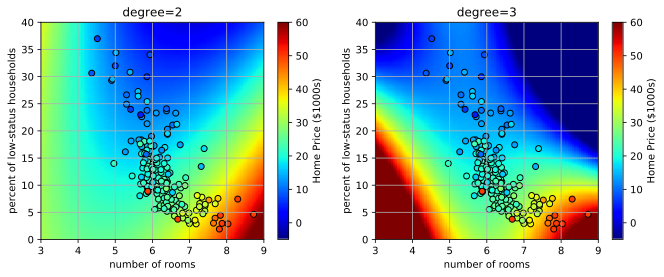

In [20]:
pfig

# Kernel Ridge Regression
- Apply _kernel trick_ to ridge regression
  - turn linear regression into non-linear regression
- Closed form solution:
  - for an input point $\mathbf{x}_*$,
    - prediction: $y_* = \mathbf{k}_* (\mathbf{K} + \alpha I) ^{-1} \mathbf{y}$
      - $\mathbf{K}$ - the kernel matrix ($N \times N$)
      - $\mathbf{k}_*$ - vector containing the kernel values between $\mathbf{x}_*$ and all training points $\mathbf{x}_i$.

# Example: Polynomial Kernel
- Note: it's the same as using polynomial features and linear regression!
  - Using the kernel, we don't need to explicitly calculate the polynomial features.
  - But, we do need to calculate the kernel function between all pairs of training points.

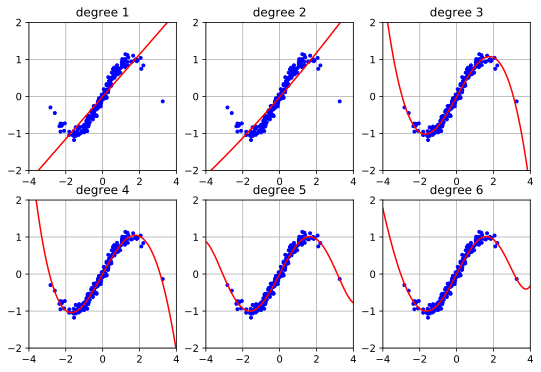

In [21]:
plt.figure(figsize=(9,6))
axbox = [-4, 4, -2, 2]

for d in [1,2,3,4,5,6]:

    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='poly', degree=d)
    krr.fit(polyX, polyY)
    
    # plot the function
    plt.subplot(2,3,d)
    plot_regr_trans_1d(krr, axbox, polyX, polyY)
    plt.title("degree " + str(d))

# Example: RBF kernel
- gamma controls the smoothness
  - small gamma will etimate a smooth function
  - large gamma will estimate a wiggly function

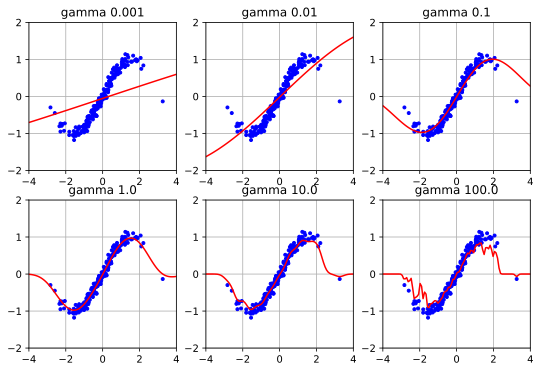

In [22]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]

for i,g in enumerate(logspace(-3,2,6)):
    # fit the parameters
    krr = kernel_ridge.KernelRidge(alpha=1, kernel='rbf', gamma=g)
    krr.fit(polyX, polyY)
    
    # plot the function
    plt.subplot(2,3,i+1)
    plot_regr_trans_1d(krr, axbox, polyX, polyY)
    plt.title("gamma " + str(g))

# Boston Data: Cross-validation
- RBF kernel
  - cross-validation to select $\alpha$ and $\gamma$.

In [23]:
# parameters for cross-validation
paramgrid = {'alpha': logspace(-3,3,10),
          'gamma': logspace(-3,3,10)}

# do cross-validation
krrcv = model_selection.GridSearchCV(
  kernel_ridge.KernelRidge(kernel='rbf'),  # estimator
  paramgrid,                              # parameters to try
  scoring='neg_mean_squared_error',       # score function
  cv=5,                                   # number of folds
  n_jobs=-1, verbose=True)
krrcv.fit(bostonX, bostonY)

print(krrcv.best_score_)
print(krrcv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
-20.406861548069113
{'gamma': 0.004641588833612777, 'alpha': 0.004641588833612777}


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.4s finished


In [24]:
(avgscores, pnames, bestind) = extract_grid_scores(krrcv, paramgrid)

kfig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(-avgscores, interpolation='nearest')
plt.plot(bestind[1], bestind[0], '*w')
plt.ylabel(pnames[0] + ' index'); plt.xlabel(pnames[1] + ' index')
plt.grid(True)
plt.title('MSE for different parameters')
plt.colorbar(); plt.axis('image');

plt.subplot(1,2,2)
plot_regr_trans_2d(krrcv, bostonaxbox2, bostonX, bostonY)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms')
plt.ylabel('percent of low-status households')
plt.title('KRR plot');
plt.close()

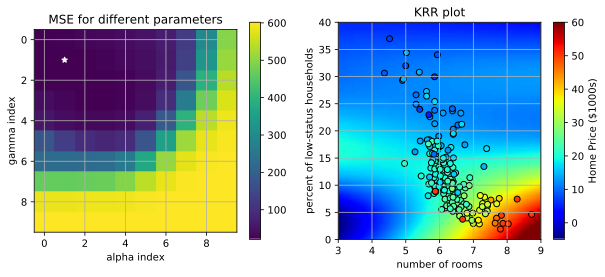

In [25]:
kfig

# Support Vector Regression (SVR)
- Borrow ideas from classification
  - Suppose we form a "band" of width $\epsilon$ around the function:
    - if a point is inside, then it is "correctly" predicted
    - if a point is outside, then it is incorrectly predicted

In [26]:
def plot_svr_1d(model, axbox, X, Y, label=False, showsv=False):
    xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
    Ypred = model.predict(xr)

    epsilon = model.epsilon
    
    plt.plot(X, Y, 'b.', label='points')
    plt.plot(xr, Ypred, 'r-', label='$f(x)$')    
    plt.plot(xr, Ypred+epsilon, 'r--', linewidth=1, label='$f(x)\\pm\\epsilon$')
    plt.plot(xr, Ypred-epsilon, 'r--', linewidth=1)
    
    if showsv:        
        ypred = model.predict(xr)
        ss = model.support_   # get support vector indicies
        plt.plot(X[ss], Y[ss], 'r.', label='support vectors')

    plt.axis(axbox); plt.grid(True)
    
    if label:
        plt.legend(loc=0)

In [27]:
epsilon = 11.5
svr = svm.SVR(C=1000, kernel='linear', epsilon=epsilon)
svr.fit(linX, linY)

axbox = [-3, 3, -50, 100]
svrfig = plt.figure()
plot_svr_1d(svr, axbox, linX, linY)
plt.grid(True); plt.axis(axbox)
plt.legend(loc='lower right')
plt.title('$\\epsilon=11.5$');
plt.close()

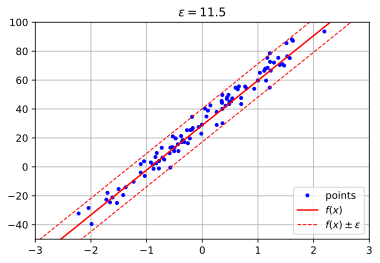

In [28]:
svrfig

- Allow some points to be outside the "tube".
  - penalty of point outside tube is controlled by $C$ parameter.
- SVR objective function:
$$\min_{\mathbf{w},b} \sum_{i=1}^N \left|y_i - (\mathbf{w}^T\mathbf{x}_i+b)\right|_{\epsilon} + \frac{1}{C}||\mathbf{w}||^2$$

- epsilon-insensitive error:
  - $\left|z\right|_{\epsilon} = \begin{cases} 0, & |z|\leq \epsilon \\ |z|-\epsilon, & |z|\gt \epsilon\end{cases}$
- Similar to SVM classifier, the points on the band will be the _support vectors_ that define the function.

# Different tube widths
- The points on the tube or outside the tube are the _support vectors_.

In [29]:
axbox = [-3, 3, -50, 100]

svrfig = plt.figure(figsize=(10,6))
ind = 1
for C in [1,10]:
    for epsilon in [5,10,25]:
        svr = svm.SVR(C=C, kernel='linear', epsilon=epsilon)
        svr.fit(linX, linY)

        plt.subplot(2,3,ind)
        plot_svr_1d(svr, axbox, linX, linY, label=False, showsv=True)
        if (C==1):
            plt.title('$\\epsilon='+str(epsilon)+"$")
        if (epsilon==5):
            plt.ylabel('C='+str(C))
        if (ind==1):
            plt.legend(fontsize=7, loc='upper left')
        ind=ind+1
plt.close()

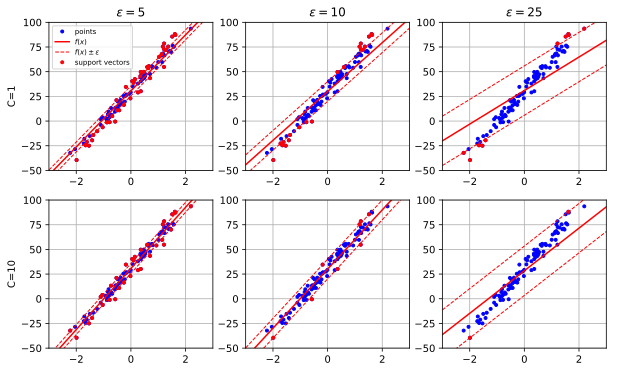

In [30]:
svrfig

# Kernel SVR
- Support vector regression can also be kernelized similar to SVM
  - turn linear regression to non-linear regression
- Polynomial Kernel:

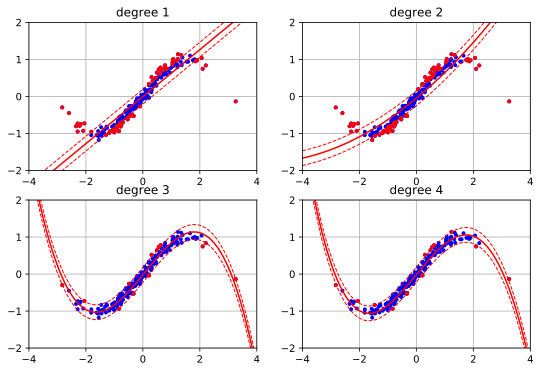

In [31]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
epsilon = 0.2

for d in [1,2,3,4]:
    # fit the parameters (poly SVR)
    svr = svm.SVR(C=1000, kernel='poly', coef0=0.1, degree=d, epsilon=epsilon)
    svr.fit(polyX, polyY)
        
    plt.subplot(2,2,d)
    plot_svr_1d(svr, axbox, polyX, polyY, showsv=True)
    plt.title("degree " + str(d))

# SVR with RBF kernel

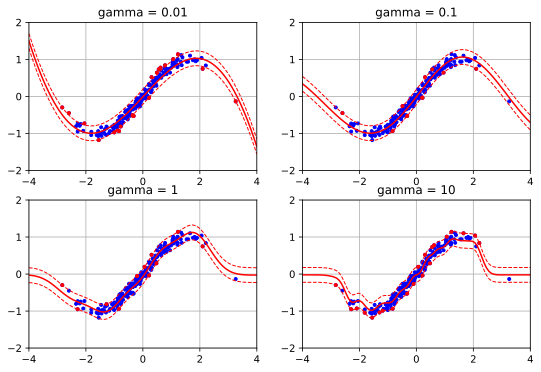

In [32]:
plt.figure(figsize=(9,6))

axbox = [-4, 4, -2, 2]
epsilon = 0.2

for i,g in enumerate([0.01, 0.1, 1, 10]):
    # fit the parameters: SVR with RBF
    svr = svm.SVR(C=1000, kernel='rbf', gamma=g, epsilon=epsilon)
    svr.fit(polyX, polyY)
        
    plt.subplot(2,2,i+1)
    plot_svr_1d(svr, axbox, polyX, polyY, showsv=True)
    plt.title("gamma = " + str(g))

# Boston Data
- Cross-validation to select 3 parameters
  - C, $\gamma$, $\epsilon$

In [33]:
# parameters for cross-validation
paramgrid = {'C':       logspace(-3,3,10),
             'gamma':   logspace(-3,3,10),
             'epsilon': logspace(-2,2,10)}

# do cross-validation 
svrcv = model_selection.GridSearchCV(
    svm.SVR(kernel='rbf'),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5, 
    n_jobs=-1, verbose=1)                # show progress
svrcv.fit(bostonX, bostonY)

print(svrcv.best_score_)
print(svrcv.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    2.2s


-19.47732071915685
{'epsilon': 1.6681005372000592, 'C': 1000.0, 'gamma': 0.004641588833612777}


[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   11.9s finished


In [34]:
(avgscores, pnames, bestind) = extract_grid_scores(svrcv, paramgrid)

kfig = plt.figure(figsize=(10,4))
# show score map
plt.subplot(1,2,1)
plt.imshow(squeeze(-avgscores[bestind[0],:,:]), interpolation='nearest')
plt.plot(bestind[2], bestind[1], '*w')
plt.ylabel(pnames[1] + ' index'); plt.xlabel(pnames[2] + ' index')
plt.grid(True)
plt.title('MSE for different parameters\n$\epsilon$={:.3f}'.format(svrcv.best_params_['epsilon']))
plt.colorbar(); plt.axis('image');

# show regression function
vmin = bostonY.min()-10
vmax = bostonY.max()+10
plt.subplot(1,2,2)
plot_regr_trans_2d(svrcv, bostonaxbox2, bostonX, bostonY)
ss = svrcv.best_estimator_.support_
plt.scatter(bostonX[ss,0], bostonX[ss,1], c=bostonY[ss], vmin=vmin, vmax=vmax, lw=2, cmap='jet', edgecolors='k')
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households');
plt.close()

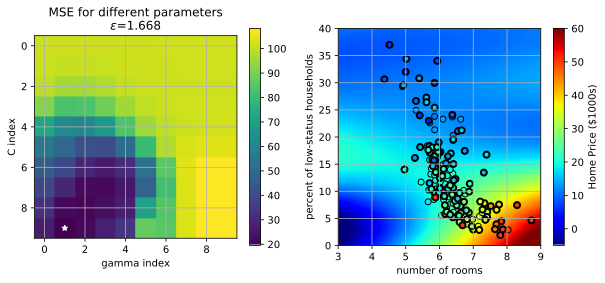

In [35]:
kfig

# Random Forest Regression
- Similar to Random Forest Classifier
  - Average predictions over many Decision Trees
    - Each decision tree sees a random sampling of the Training set
    - Each split in the decision tree uses a random subset of features
    - Leaf node of tree contains the predicted value.

In [36]:
def plot_rf_1d(model, axbox, X, Y, label=False, showdt=False):
    xr = linspace(axbox[0], axbox[1], 100).reshape(100,1)
    Ypred = model.predict(xr)

    if showdt:
        myalpha=0.25
    else:
        myalpha=1.0
    plt.plot(X, Y, 'b.', label='points', alpha=myalpha)
    
    if showdt:
        for i in model.estimators_:
            yy = i.predict(xr)
            plt.plot(xr, yy, 'm-')
    
    plt.plot(xr, Ypred, 'r-', label='forest', lw=2)
    plt.axis(axbox); plt.grid(True)
    
    if label:
        plt.legend(loc=0)

# Example
- Four decision trees
  - the regressed function has "steps" because of the decision tree has a constant prediction for ranges of feature values.

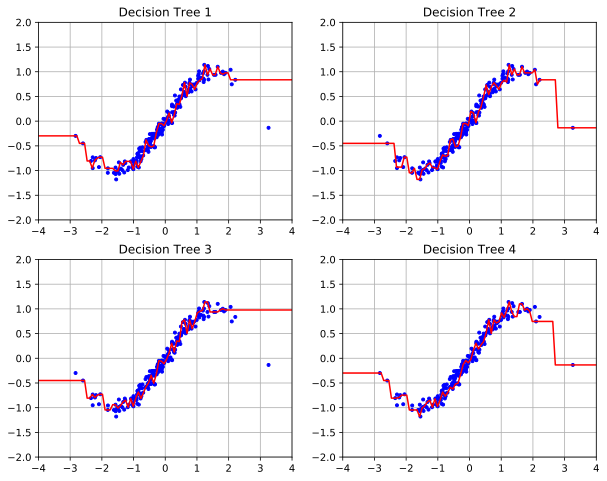

In [37]:
axbox = [-4, 4, -2, 2]
rf = ensemble.RandomForestRegressor(n_estimators=4, random_state=4487, n_jobs=-1)
rf.fit(polyX, polyY)

plt.figure(figsize=(10,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plot_regr_trans_1d(rf.estimators_[i], axbox, polyX, polyY)
    plt.title('Decision Tree ' + str(i+1))

Text(0.5,1,'Random Forest Regressor w/ 4 trees')

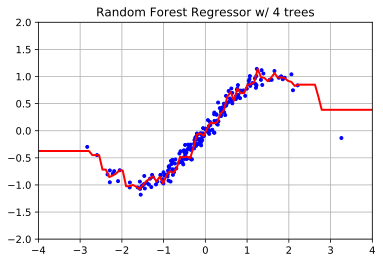

In [38]:
# the aggregated function
plt.figure()
plot_rf_1d(rf, axbox, polyX, polyY)
plt.title('Random Forest Regressor w/ 4 trees')

- Using more trees...

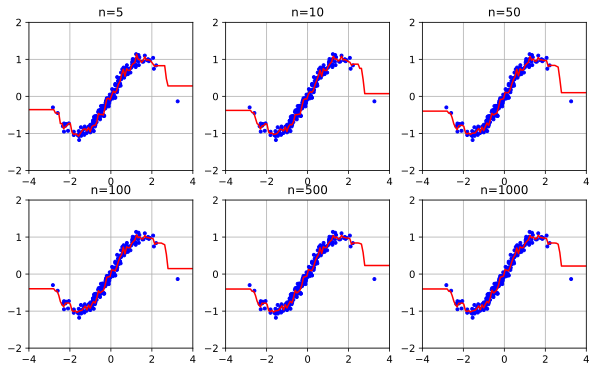

In [39]:
plt.figure(figsize=(10,6))
for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    plt.subplot(2,3,i+1)
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(polyX, polyY)

    plot_regr_trans_1d(rf, axbox, polyX, polyY)
    plt.title('n='+str(n))

# Boston data
- The regressed function looks "blocky"
  - looks more reasonable for areas without any data

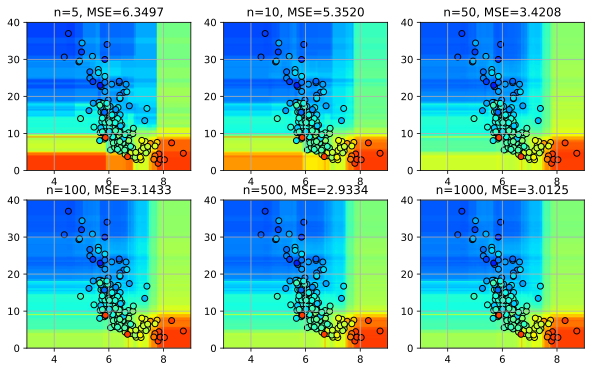

In [40]:
plt.figure(figsize=(10,6))
for i,n in enumerate([5, 10, 50, 100, 500, 1000]):
    plt.subplot(2,3,i+1)
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(bostonX, bostonY)
    MSE = metrics.mean_squared_error(bostonY, rf.predict(bostonX))

    plot_regr_trans_2d(rf, bostonaxbox2, bostonX, bostonY)
    plt.title('n={}, MSE={:.4f}'.format(n, MSE))

- plot of MSE versus number of trees

In [41]:
ns = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 50, 100, 500, 1000]
mses = []
for n in ns:
    rf = ensemble.RandomForestRegressor(n_estimators=n, random_state=4487, n_jobs=-1)
    rf.fit(bostonX, bostonY)
    
    MSE = metrics.mean_squared_error(bostonY, rf.predict(bostonX))
    mses.append(MSE)

mfig = plt.figure(figsize=(8,4))
plt.semilogx(ns, mses, 'b.-')
plt.xlabel('num trees')
plt.ylabel('MSE')
plt.grid(True)
plt.close()

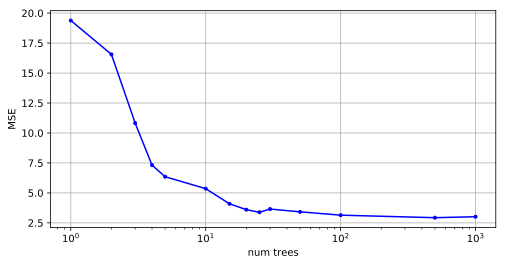

In [42]:
mfig

- Use cross-validation to select the tree depth

In [43]:
# parameters for cross-validation
paramgrid = {'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]),
            }

# do cross-validation
rfcv = model_selection.GridSearchCV(
    ensemble.RandomForestRegressor(n_estimators=100, random_state=4487),  # estimator
    paramgrid,                     # parameters to try
    scoring='neg_mean_squared_error',  # score function
    cv=5,
    n_jobs=-1, verbose=True
)
rfcv.fit(bostonX, bostonY)

print(rfcv.best_score_)
print(rfcv.best_params_)

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:   11.5s finished


-21.419077779026953
{'max_depth': 4}


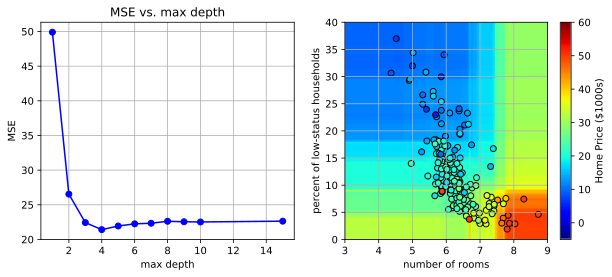

In [44]:
(avgscores, pnames, bestind) = extract_grid_scores(rfcv, paramgrid)

plt.figure(figsize=(10,4))
# show scores
plt.subplot(1,2,1)
plt.plot(paramgrid['max_depth'], -avgscores, 'bo-')
plt.xlabel('max depth'); plt.ylabel('MSE')
plt.title('MSE vs. max depth')
plt.grid(True)

# show regression function
plt.subplot(1,2,2)
plot_regr_trans_2d(rfcv, bostonaxbox2, bostonX, bostonY)
cbar = plt.colorbar()
cbar.set_label('Home Price ($1000s)')
plt.xlabel('number of rooms'); plt.ylabel('percent of low-status households');

# Regression Summary
- **Goal:** predict output $y\in\mathbb{R}$ from input $\mathbf{x}\in\mathbb{R}^d$.
  - i.e., learn the function $y = f(\mathbf{x})$.

<table style="font-size:9pt;">
<tr>
<th>Name</th>
<th>Function</th>
<th>Training</th>
<th>Advantages</th>
<th>Disadvantages</th>
</tr>
<tr>
<td>Ordinary Least Squares</td>
<td>linear</td>
<td>minimize square error between observation and predicted output.</td>
<td>- closed-form solution.</td>
<td>- sensitive to outliers and overfitting.</td>
</tr>
<tr>
<td>ridge regression</td>
<td>linear</td>
<td>minimize squared error with $||w||^2$ regularization term.</td>
<td>- closed-form solution;<br>- shrinkage to prevent overfitting.</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>LASSO</td>
<td>linear</td>
<td>minimize squared error with $\sum_{j=1}^d|w_j|$ regularization term.</td>
<td>- feature selection (by forcing weights to 0)</td>
<td>- sensitive to outliers.</td>
</tr>
<tr>
<td>RANSAC</td>
<td>same as the base model</td>
<td>randomly sample subset of training data and fit model; keep model with most inliers.</td>
<td>- ignores outliers.</td>
<td>- requires enough iterations to find good consensus set.</td>
</tr>
<tr>
<td>kernel ridge regression</td>
<td>non-linear (kernel function)</td>
<td>apply "kernel trick" to ridge regression.</td>
<td>- non-linear regression. <br>- Closed-form solution.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- cross-validation to select hyperparameters.</td>
</tr>
<tr>
<td>kernel support vector regression</td>
<td>non-linear (kernel function)</td>
<td>minimize squared error, insensitive to epsilon-error.</td>
<td>- non-linear regression.<br>- faster predictions than kernel ridge regression.</td>
<td>- requires calculating kernel matrix $O(N^2)$.<br>- iterative solution (slow).<br>- cross-validation to select hyperparameters.</td>
</tr>
<tr>
<td>random forest regression</td>
<td>non-linear (ensemble)</td>
<td>aggregate predictions from decision trees.</td>
<td>- non-linear regression.<br>- fast predictions.</td>
<td>- predicts step-wise function.<br>- cannot learn a completely smooth function.</td>
</tr>
</table>

# Other Things
- _Feature normalization_
  - feature normalization is typically required for regression methods with regularization.
  - makes ordering of weights more interpretable (LASSO, RR).
- _Output transformations_
  - sometimes the output values $y$ have a large dynamic range (e.g., $10^{-1}$ to $10^5$).
    - large output values will have large error, which will dominate the training error.
  - in this case, it is better to transform the output values using the logarithm function.
    - $\hat{y} = \log_{10} (y)$
  - For example, see the tutorial.